## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [11]:
from keras.layers import BatchNormalization,Dropout
from keras.regularizers import l1, l2, l1_l2

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128, 64], drop_ratio=0.2, Drop = False, l1_l2_ratio=1e-4, L1_L2 = False, BN = False):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            if(L1_L2 == True):
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1),
                                       kernel_regularizer=l1_l2(l1_l2_ratio))(input_layer)
            else:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1))(input_layer)
            if(Drop == True):
                x = Dropout(drop_ratio)(x)
            if(BN == True):
                x = BatchNormalization()(x)
                
        else:
            if(L1_L2 == True):
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1),
                                       kernel_regularizer=l1_l2(l1_l2_ratio))(x)
            else:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1))(x)
            
            if(Drop == True):
                x = Dropout(drop_ratio)(x)
            if(BN == True):
                x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [12]:
def RegulationType(idx):
    Drop = False
    L1_L2 = False
    BN = False
    if((idx & 0x01) != 0x00):
        Drop = True
    if((idx & 0x02) != 0x00):
        L1_L2 = True
    if((idx & 0x04) != 0x00):
        BN = True
    return Drop, L1_L2, BN

In [13]:
LEARNING_RATE = 1e-3
EPOCHS = 20
BATCH_SIZE = 256
MOMENTUM = 0.95
Dropout_rate = 0.5
regulizer_ratio = 1e-12

In [14]:
results = {}

keras.backend.clear_session() # 把舊的 Graph 清掉
for i in range(8):
    option = RegulationType(i)
    print("Drop is {0}, L1_L2 is {1}, BN is {2}".format(str(option[0]), str(option[1]), str(option[2])))
    model = build_mlp(input_shape=x_train.shape[1:], drop_ratio = Dropout_rate, Drop = option[0], l1_l2_ratio=regulizer_ratio, L1_L2 = option[1] ,BN = option[2])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "Drop is {0}, L1_L2 is {1}, BN is {2}".format(str(option[0]), str(option[1]), str(option[2]))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Drop is False, L1_L2 is False, BN is False
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
hidden_layer4 (Dense)        (None, 64)                8256      
_________________________________________________________________
output (Dense)               (None, 10)                650       
Total params: 1,746,506
Trainable params: 1,746,506
Non-trainable params: 0
_______________________

W0809 11:13:24.432304  1088 deprecation.py:506] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Drop is True, L1_L2 is False, BN is False
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None

50000/50000 [==============================] - 12s 238us/step - loss: 2.7231 - acc: 0.4561 - val_loss: 2.6795 - val_acc: 0.4422
Epoch 19/20
50000/50000 [==============================] - 12s 239us/step - loss: 2.5832 - acc: 0.4582 - val_loss: 2.5534 - val_acc: 0.4370
Epoch 20/20
50000/50000 [==============================] - 12s 241us/step - loss: 2.4605 - acc: 0.4609 - val_loss: 2.4202 - val_acc: 0.4595
Drop is True, L1_L2 is True, BN is False
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)  

50000/50000 [==============================] - 9s 170us/step - loss: 1.0707 - acc: 0.6256 - val_loss: 1.5342 - val_acc: 0.4682
Epoch 12/20
50000/50000 [==============================] - 9s 171us/step - loss: 1.0360 - acc: 0.6380 - val_loss: 1.5176 - val_acc: 0.4851
Epoch 13/20
50000/50000 [==============================] - 9s 179us/step - loss: 0.9951 - acc: 0.6523 - val_loss: 1.4954 - val_acc: 0.4862
Epoch 14/20
50000/50000 [==============================] - 9s 178us/step - loss: 0.9598 - acc: 0.6651 - val_loss: 1.6448 - val_acc: 0.4567
Epoch 15/20
50000/50000 [==============================] - 9s 180us/step - loss: 0.9220 - acc: 0.6800 - val_loss: 1.5825 - val_acc: 0.4674
Epoch 16/20
50000/50000 [==============================] - 10s 194us/step - loss: 0.8947 - acc: 0.6913 - val_loss: 1.5968 - val_acc: 0.4785
Epoch 17/20
50000/50000 [==============================] - 10s 194us/step - loss: 0.8617 - acc: 0.7014 - val_loss: 1.6775 - val_acc: 0.4618
Epoch 18/20
50000/50000 [============

50000/50000 [==============================] - 15s 303us/step - loss: 15.7558 - acc: 0.3448 - val_loss: 14.5855 - val_acc: 0.3663
Epoch 2/20
50000/50000 [==============================] - 13s 263us/step - loss: 13.4453 - acc: 0.4443 - val_loss: 12.6016 - val_acc: 0.4156
Epoch 3/20
50000/50000 [==============================] - 14s 279us/step - loss: 11.6069 - acc: 0.4860 - val_loss: 11.0320 - val_acc: 0.4102
Epoch 4/20
50000/50000 [==============================] - 13s 264us/step - loss: 10.0599 - acc: 0.5104 - val_loss: 9.5742 - val_acc: 0.4489
Epoch 5/20
50000/50000 [==============================] - 13s 263us/step - loss: 8.7384 - acc: 0.5348 - val_loss: 8.3831 - val_acc: 0.4519
Epoch 6/20
50000/50000 [==============================] - 14s 271us/step - loss: 7.6137 - acc: 0.5547 - val_loss: 7.4552 - val_acc: 0.4364
Epoch 7/20
50000/50000 [==============================] - 17s 338us/step - loss: 6.6645 - acc: 0.5668 - val_loss: 6.5549 - val_acc: 0.4584
Epoch 8/20
50000/50000 [=======

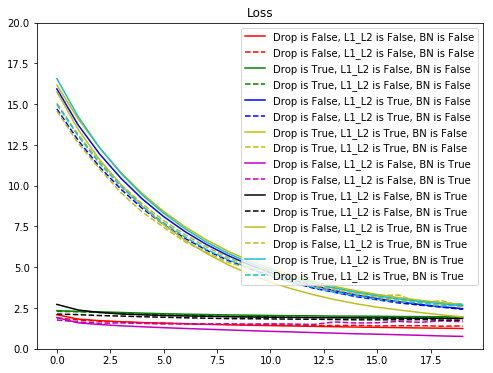

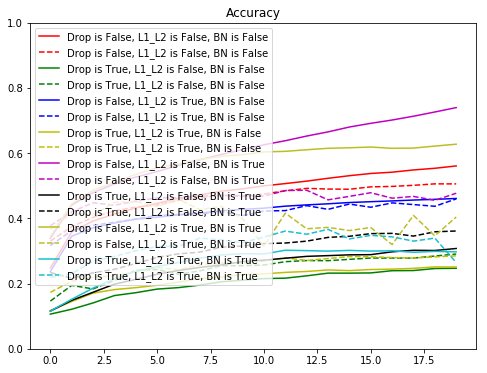

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

color_bar = ["r", "g", "b", "y", "m", "k", 'tab:olive', 'tab:cyan']

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 20])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.ylim([0, 1])
plt.legend()
plt.show()